In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


ndvi = np.load("NDVI_singur_monsoon.npy")
ndmi = np.load("NDMI_singur_monsoon.npy")

print("NDVI shape:", ndvi.shape)
print("NDMI shape:", ndmi.shape)


def flatten_array(arr):
    if arr.ndim == 2:   # single image
        return arr.ravel()
    elif arr.ndim == 3: # time-series cube
        return arr.reshape(-1)
    else:               # already 1D
        return arr

ndvi_flat = flatten_array(ndvi)
ndmi_flat = flatten_array(ndmi)



plant_vigor = np.zeros_like(ndvi_flat, dtype=int)
plant_vigor[ndvi_flat >= 0.5] = 1   # High vigor if NDVI >= 0.5


leaf_wetness_binary = plant_vigor.copy()

np.save("plant_vigor_labels.npy", plant_vigor)
np.save("leaf_wetness_binary_labels.npy", leaf_wetness_binary)
print("\nProxy labels created:")
print(" - plant_vigor_labels.npy (0=Low, 1=High)")
print(" - leaf_wetness_binary_labels.npy (0=Low Wetness, 1=High Wetness)")


n_samples = 50000  # adjust if you want more/less
if len(ndvi_flat) > n_samples:
    idx = np.random.choice(len(ndvi_flat), size=n_samples, replace=False)
    X = np.column_stack([ndvi_flat[idx], ndmi_flat[idx]])
    y = leaf_wetness_binary[idx]
else:
    X = np.column_stack([ndvi_flat, ndmi_flat])
    y = leaf_wetness_binary


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = RandomForestClassifier(n_estimators=50, max_depth=8, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print(classification_report(y_test, y_pred, target_names=["Low Wetness", "High Wetness"], digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


full_predictions = clf.predict(np.column_stack([ndvi_flat, ndmi_flat]))
np.save("leaf_wetness_pred.npy", full_predictions)

print("\nPredictions saved as leaf_wetness_pred.npy")


NDVI shape: (26365727, 1)
NDMI shape: (26365727, 1)

Proxy labels created:
 - plant_vigor_labels.npy (0=Low, 1=High)
 - leaf_wetness_binary_labels.npy (0=Low Wetness, 1=High Wetness)
              precision    recall  f1-score   support

 Low Wetness      1.000     1.000     1.000      3653
High Wetness      1.000     1.000     1.000      6347

    accuracy                          1.000     10000
   macro avg      1.000     1.000     1.000     10000
weighted avg      1.000     1.000     1.000     10000

Confusion Matrix:
 [[3652    1]
 [   0 6347]]

Predictions saved as leaf_wetness_pred.npy



 NDVI :  0.1
 NDMI :  0.23



Result: Low Wetness
Alert: ⚠️ Alert: Leaf wetness is critically low!


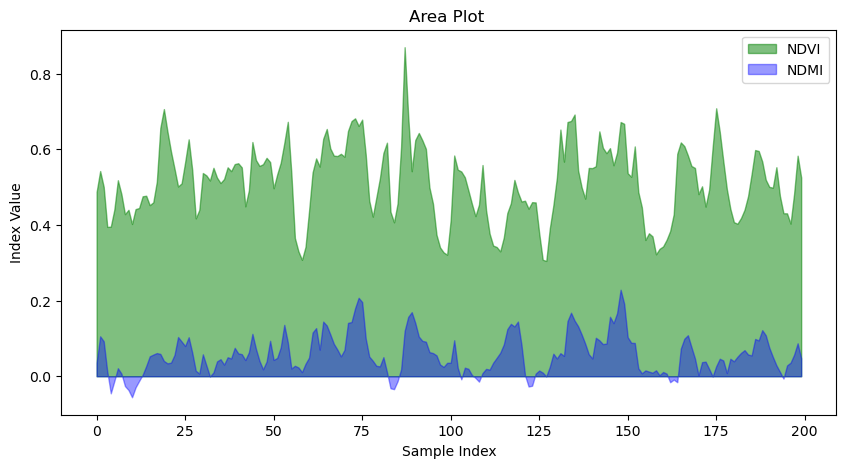

C:\Users\MAINAK\AppData\Local\Temp\ipykernel_14992\3777219347.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["Predicted Wetness"], y=df["NDVI"], palette="Greens")
C:\Users\MAINAK\AppData\Local\Temp\ipykernel_14992\3777219347.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["Predicted Wetness"], y=df["NDMI"], palette="Blues")


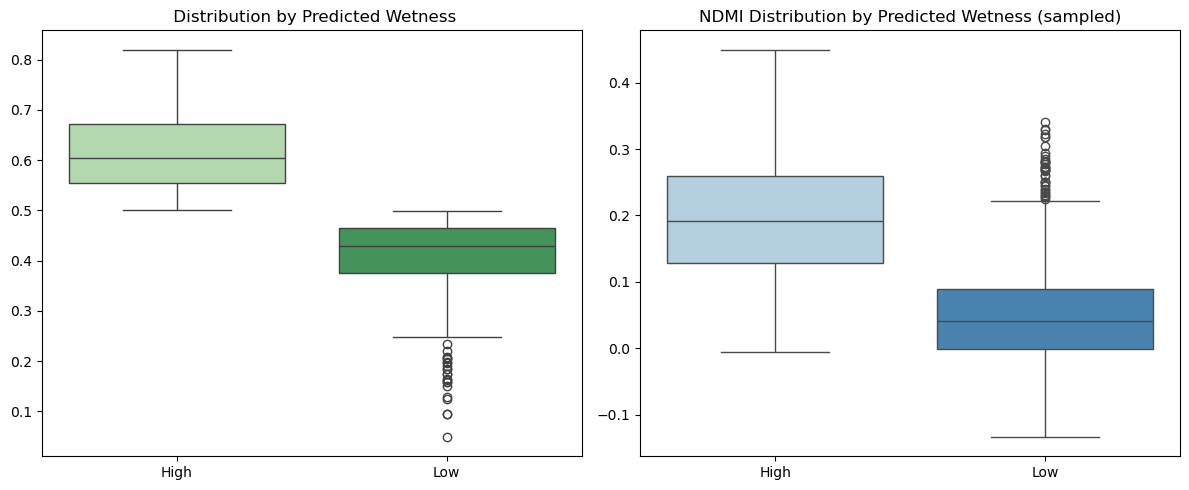

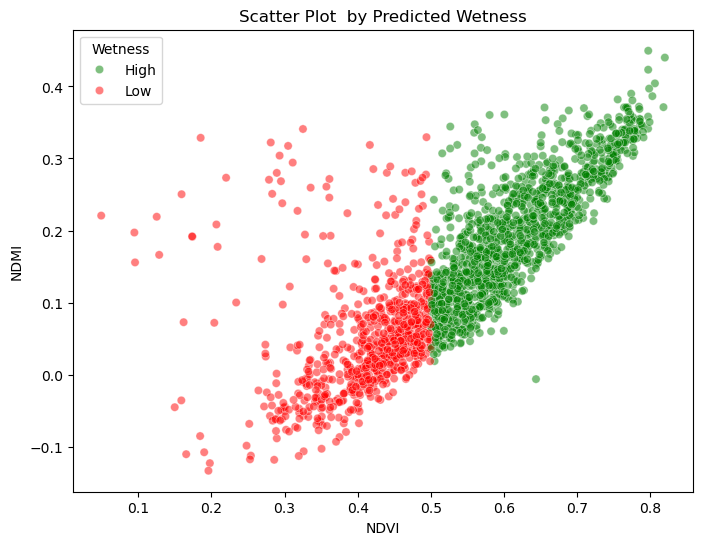


 NDVI :  quit


Exiting...


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

alerts = {
    "Low Wetness":  "⚠️ Alert: Leaf wetness is critically low!",
    "High Wetness": "✅ Good wetness level, conditions are healthy."
}

labels = {0: "Low Wetness", 1: "High Wetness"}

while True:
    try:
        ndvi_val = input("\n NDVI : ")
        if ndvi_val.lower() == 'quit':   # user can type quit anytime
            print("Exiting...")
            break

        ndvi_val = float(ndvi_val)
        ndmi_val = float(input(" NDMI : "))

        user_input = np.array([[ndvi_val, ndmi_val]])
        pred = clf.predict(user_input)[0]
        predicted_label = labels[pred]

        # ---- Result & Alert ----
        print(f"\nResult: {predicted_label}")
        print("Alert:", alerts[predicted_label])

        # ---- Plots ----

        # 1. Area Plot (NDVI & NDMI sample trend)
        plt.figure(figsize=(10,5))
        plt.fill_between(range(200), ndvi_flat[:200], color="green", alpha=0.5, label="NDVI")
        plt.fill_between(range(200), ndmi_flat[:200], color="blue", alpha=0.4, label="NDMI")
        plt.title("Area Plot ")
        plt.xlabel("Sample Index")
        plt.ylabel("Index Value")
        plt.legend()
        plt.show()

        # 2. Box Plot (NDVI & NDMI grouped by Predicted Wetness for limited samples)
        pred_labels = clf.predict(np.column_stack([ndvi_flat, ndmi_flat]))

        # Take random 2000 samples for cleaner plot
        sample_size = 2000
        idx = np.random.choice(len(ndvi_flat), size=min(sample_size, len(ndvi_flat)), replace=False)

        df = {
            "NDVI": ndvi_flat[idx],
            "NDMI": ndmi_flat[idx],
            "Predicted Wetness": ["High" if p==1 else "Low" for p in pred_labels[idx]]
        }

        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        sns.boxplot(x=df["Predicted Wetness"], y=df["NDVI"], palette="Greens")
        plt.title(" Distribution by Predicted Wetness")

        plt.subplot(1,2,2)
        sns.boxplot(x=df["Predicted Wetness"], y=df["NDMI"], palette="Blues")
        plt.title("NDMI Distribution by Predicted Wetness (sampled)")
        plt.tight_layout()
        plt.show()

        # 3. Scatter Plot (NDVI vs NDMI, colored by Predicted Wetness)
        plt.figure(figsize=(8,6))
        sns.scatterplot(x=df["NDVI"], y=df["NDMI"], hue=df["Predicted Wetness"], 
                        palette={"Low":"red", "High":"green"}, alpha=0.5)
        plt.title("Scatter Plot  by Predicted Wetness")
        plt.xlabel("NDVI")
        plt.ylabel("NDMI")
        plt.legend(title="Wetness")
        plt.show()

    except Exception as e:
        print("Invalid input, try again!", e)
